In this notebook we are going to integrate two publicly avaible datasets, thanks to both authors and teams for providing detailed datasets that make this integration possible.

RNA-seq dataset: https://www.biorxiv.org/content/10.1101/2023.03.06.531398v2


ATAc-seq dataset: https://www.nature.com/articles/s41597-023-02373-y#Sec18

In [ ]:
!pip install scvi-tools scanpy leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.2/380.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.8 MB/s

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt

# **RNA-seq Exploratory Analysis**

Let's do some data cleaning and pre-processing. We are going to use only 3 timepoints (10hpf, 12hpf, 24hpf) that are common in both datasets.

In [ ]:
adata = sc.read_h5ad('zf_atlas_full_v4_release.h5ad')

selected_time_points = ["10hpf", "12hpf", "24hpf"]
# Filter the AnnData object to keep only cells from the selected time points
adata = adata[adata.obs['timepoint'].isin(selected_time_points)].copy()

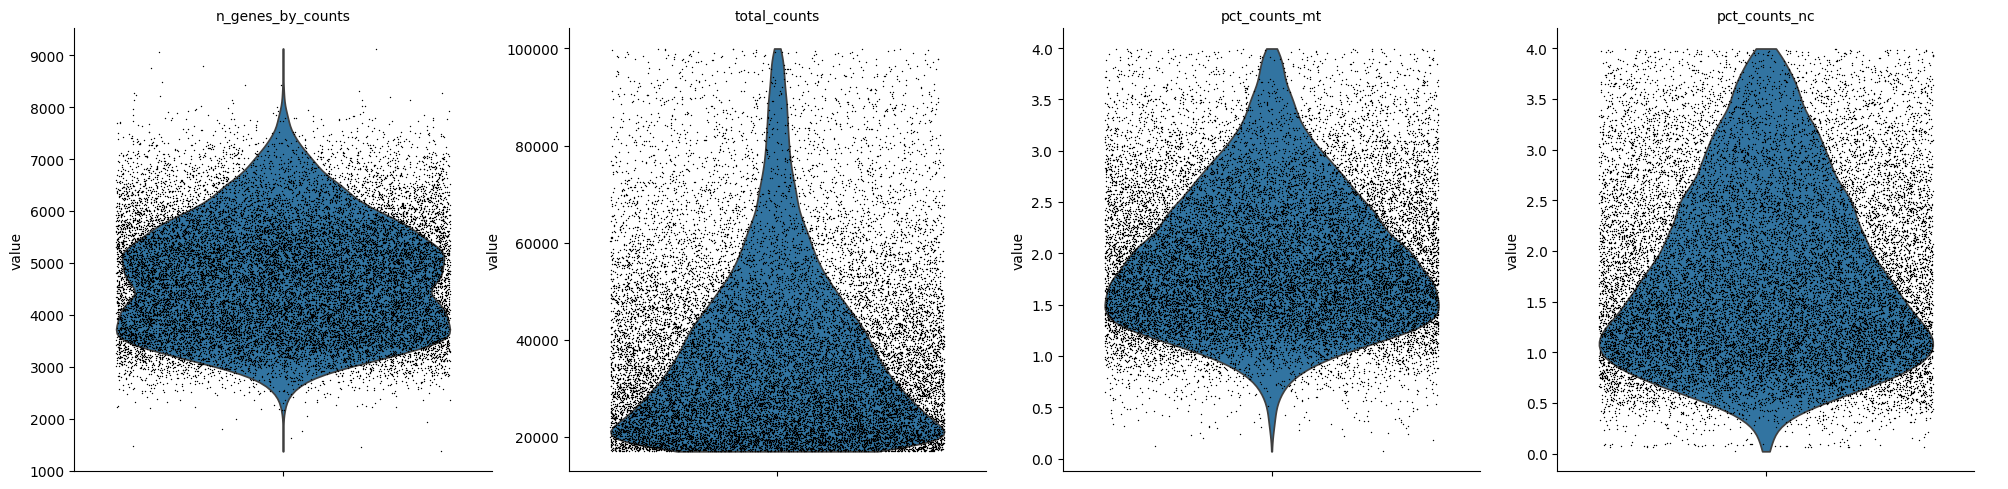

In [ ]:
### Sort the adata object by the number of cells by counts
adata.var.sort_values('n_cells_by_counts')

### Filter by minimum number of cells expressed required for a gene to pass filtering. I.e. retain genes that are expressed in at least 3 cells
sc.pp.filter_genes(adata, min_cells=3)

### Retain cells that have at least 200 expressed genes
sc.pp.filter_cells(adata, min_genes=200)

### Make violin plots based on certain parameters

sc.pl.violin(adata,['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_nc'],jitter=0.4, multi_panel=True)

### Retain cells having mito % less than 10

adata = adata[adata.obs.pct_counts_mt < 10]

### Retain cells having nc % less than 4

adata = adata[adata.obs.pct_counts_nc < 4]


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


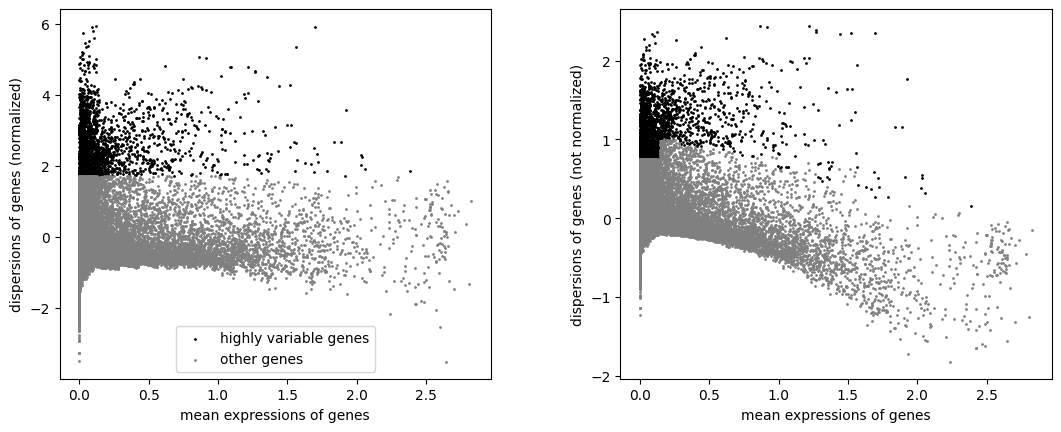

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


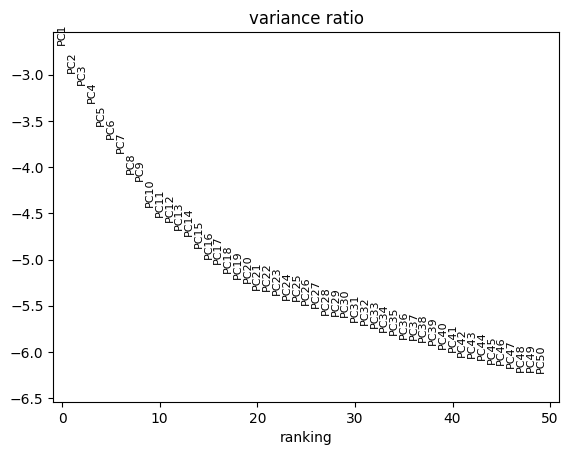

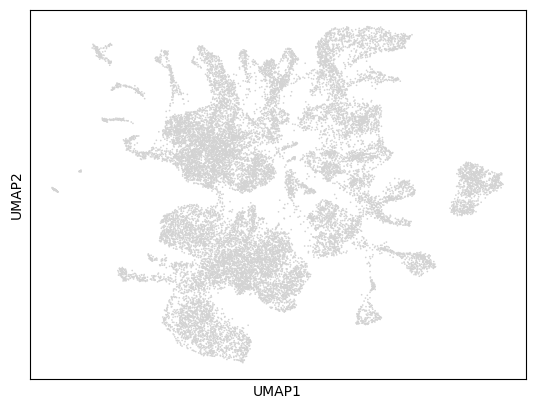

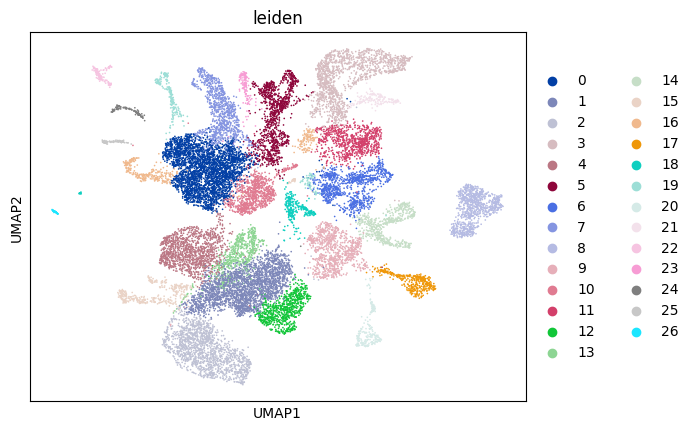

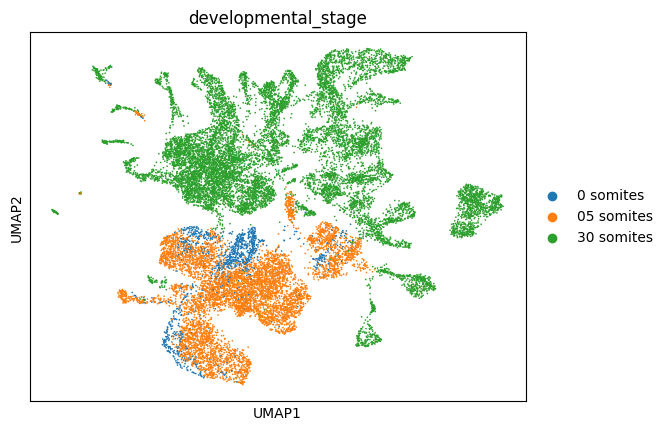

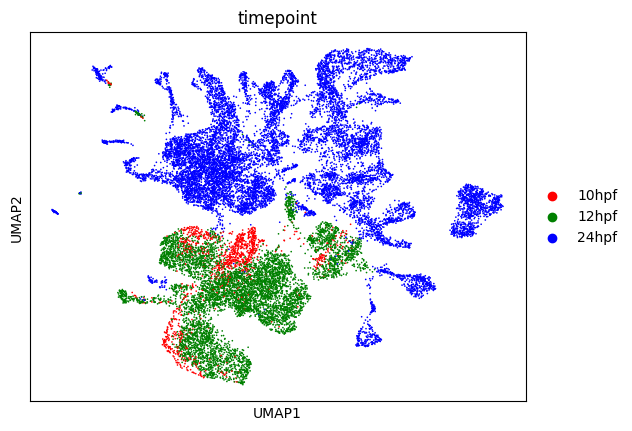

In [ ]:
### Normalize data to
sc.pp.normalize_total(adata, target_sum=1e4)


### Transform to log scape
sc.pp.log1p(adata)

### Keep the raw data of the adata in a new object
adata.raw = adata


#################################################################################
################################### Clustering ##################################
#################################################################################

### Find top 2000 variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)


### Plot these genes
sc.pl.highly_variable_genes(adata)

### Select only those genes
adata = adata[:, adata.var.highly_variable]

### Regress out the influence from mitochondrial and non-coding genes
sc.pp.regress_out(adata,['total_counts','pct_counts_mt','pct_counts_nc'])

### Scale the data
sc.pp.scale(adata,max_value=10)


### Copute the Principal Components
sc.tl.pca(adata, svd_solver='arpack')

### Plot the first 50 PCs
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)


### Find nearest neighbors
sc.pp.neighbors(adata, n_pcs=30)


### Compute the UMAP
sc.tl.umap(adata)


### Plot the UMAP
sc.pl.umap(adata)

### Find clusters with Leiden method
sc.tl.leiden(adata, resolution=0.5)


### Coloring based on identified clusters using Leiden method
sc.pl.umap(adata, color=['leiden'])


### Coloring based on developmental stage
sc.pl.umap(adata, color=['developmental_stage'])


### Coloring based on time point
sc.pl.umap(adata, color='timepoint', palette=['red', 'green', 'blue'])


# **ATAC-seq Exploratory Analysis**

Let's do the same for ATAC-seq data too.

In [ ]:
adata_atac = ad.read_h5ad('/content/drive/MyDrive/ATACseq.h5ad')
adata_atac.obs['timepoint'] = adata_atac.obs.index.map(lambda x: x.split('_')[0])


# Filter the AnnData object to keep only cells from the selected time points
selected_time_points = ["10hpf", "12hpf", "24hpf"]
adata_atac = adata_atac[adata_atac.obs['timepoint'].isin(selected_time_points)].copy()

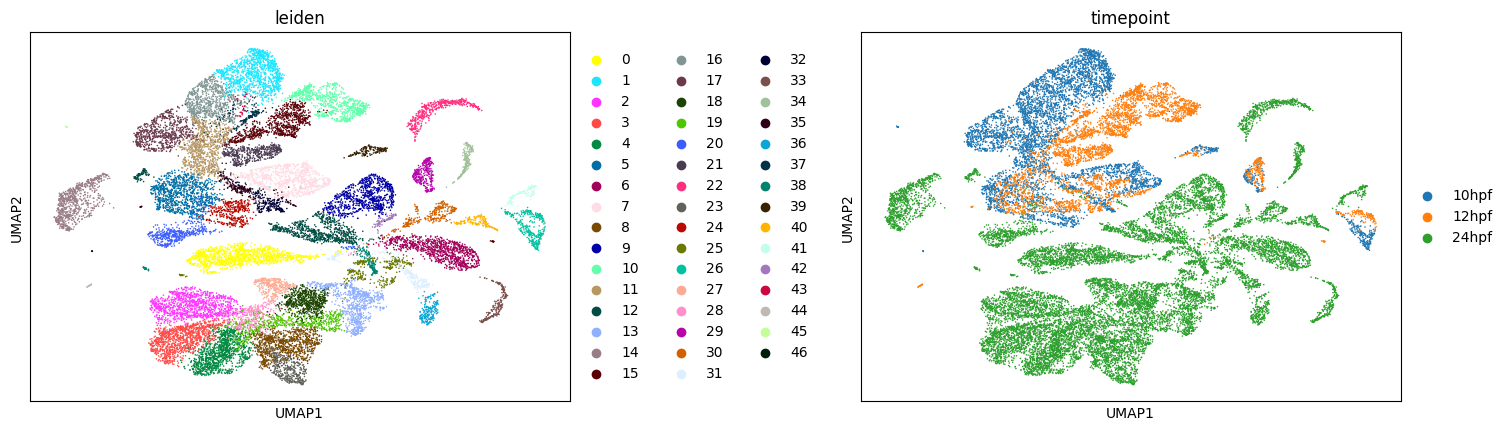

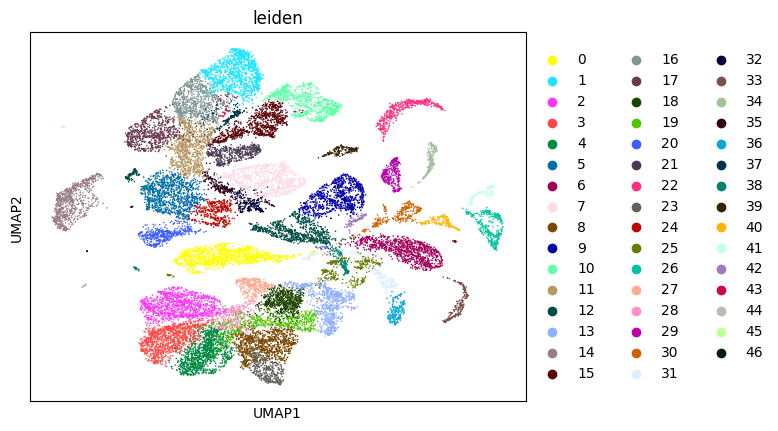

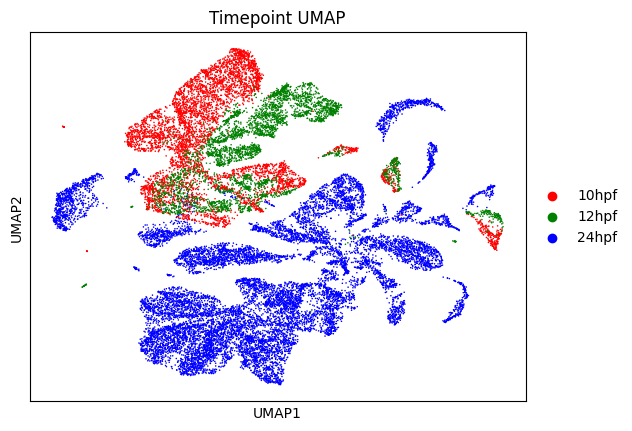

In [ ]:
sc.pp.normalize_total(adata_atac, target_sum=1e4)
sc.pp.log1p(adata_atac)  # Logarithmize the data
sc.pp.pca(adata_atac, n_comps=50)  # Adjust 'n_comps' as needed

# Neighbors, tSNE, UMAP, etc.
sc.pp.neighbors(adata_atac, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_atac)
sc.tl.tsne(adata_atac)
sc.tl.leiden(adata_atac)  # Clustering

# Plot UMAP
sc.pl.umap(adata_atac, color=['leiden', 'timepoint'], wspace=0.4)

sc.pl.umap(adata_atac, color=['leiden'], wspace=0.4)
sc.pl.umap(adata_atac, color='timepoint', palette=['red', 'green', 'blue'], title='Timepoint UMAP')



# **Training scVI model**

Great, now we can integrate our datasets using scVI tools. We will train two models, one for each dataset, that would give us the embedding with the size of 50 for each cell. We will use only one of the time points to make training faster. You can technically use as many as you want if you are not bounded by training time or compute resources.

In [ ]:
selected_time_points = ["12hpf"]
# Filter the AnnData object to keep only cells from the selected time points
adata_rna12 = adata[adata.obs['timepoint'].isin(selected_time_points)].copy()
adata_rna12

In [ ]:


scvi.model.SCVI.setup_anndata(adata_rna12)
model_rna = scvi.model.SCVI(adata_rna12,n_latent=50)
model_rna.train()

/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a 

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/400:   0%|          | 1/400 [00:03<25:44,  3.87s/it, v_num=1, train_loss_step=1e+4, train_loss_epoch=1.18e+4]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 400/400: 100%|██████████| 400/400 [05:15<00:00,  1.30it/s, v_num=1, train_loss_step=6.71e+3, train_loss_epoch=6.78e+3]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:15<00:00,  1.27it/s, v_num=1, train_loss_step=6.71e+3, train_loss_epoch=6.78e+3]


In [ ]:
adata_rna12.obsm['X_scVI'] = model_rna.get_latent_representation()


In [ ]:
import scanpy as sc
import scvi



adata_atac.obs['timepoint'] = adata_atac.obs.index.map(lambda x: x.split('_')[0])

selected_time_points = ["12hpf"]
adata_atac12 = adata_atac[adata_atac.obs['timepoint'].isin(selected_time_points)]
sc.pp.normalize_total(adata_atac12, target_sum=1e4)
sc.pp.log1p(adata_atac12)


scvi.model.SCVI.setup_anndata(adata_atac12)
model_atac = scvi.model.SCVI(adata_atac12,n_latent=50)
model_atac.train()

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU availab

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/400:   0%|          | 1/400 [00:11<1:16:36, 11.52s/it, v_num=1, train_loss_step=2.4e+4, train_loss_epoch=2.42e+4]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 400/400: 100%|██████████| 400/400 [1:17:32<00:00, 11.65s/it, v_num=1, train_loss_step=1.37e+4, train_loss_epoch=1.35e+4]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [1:17:32<00:00, 11.63s/it, v_num=1, train_loss_step=1.37e+4, train_loss_epoch=1.35e+4]


In [ ]:
adata_rna12 = sc.read_h5ad('/content/drive/MyDrive/adata_rna12.h5ad')
adata_atac12 = sc.read_h5ad('/content/drive/MyDrive/adata_atac12.h5ad')



Now we can contacenate two models embeddings and visualize them using UMAP techniques and color them with leiden algorithm.

<ipython-input-5-e67cc2303482>:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined, resolution=0.5)


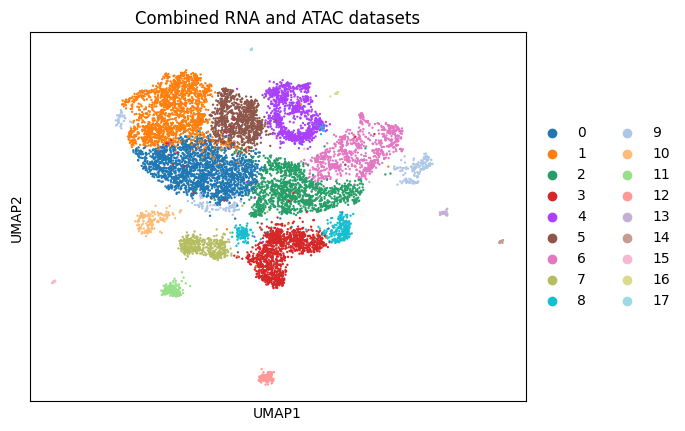

In [ ]:
import pandas as pd
import numpy as np

# Concatenate the latent spaces
latent_rna = adata_rna12.obsm['X_scVI']
latent_atac = adata_atac12.obsm['X_scVI']

# Create a new Anndata object containing both embeddings
combined_latent = np.vstack([latent_rna, latent_atac])
adata_combined = sc.AnnData(X=combined_latent)

# Perform clustering on the combined dataset
sc.pp.neighbors(adata_combined, use_rep='X')
sc.tl.leiden(adata_combined, resolution=0.5)

# Compute UMAP for visualization
sc.tl.umap(adata_combined)
sc.pl.umap(adata_combined, color='leiden', title='Combined RNA and ATAC datasets')

In this part, we are going to transfer labels from RNA-seq data to ATAC-seq data using nearest neighbors technique.




In [ ]:
from sklearn.neighbors import NearestNeighbors

rna_embeddings = adata_rna12.obsm['X_scVI']
atac_embeddings = adata_atac12.obsm['X_scVI']

# Initialize and fit the Nearest Neighbors model (using k=1 for the simplest case)
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(rna_embeddings)

# Find the nearest neighbors in the RNA-seq data for each cell in the ATAC-seq data
distances, indices = nn.kneighbors(atac_embeddings)

# Transfer the labels
adata_atac12.obs['transferred_labels'] = adata_rna12.obs['zebrafish_anatomy_ontology_class'].values[indices.flatten()]

# Optionally, print out or return the updated ATAC-seq AnnData object
print(adata_atac12.obs)


                           orig.ident  nCount_RNA  nFeature_RNA timepoint  \
12hpf_2#12hpf_2_BC0017_N01      12hpf       21164          9749     12hpf   
12hpf_2#12hpf_2_BC0018_N01      12hpf       23858         10977     12hpf   
12hpf_2#12hpf_2_BC0027_N01      12hpf       22724         10133     12hpf   
12hpf_2#12hpf_2_BC0039_N02      12hpf       22626         10046     12hpf   
12hpf_2#12hpf_2_BC0033_N01      12hpf       19056          8788     12hpf   
...                               ...         ...           ...       ...   
12hpf_3#12hpf_3_BC0985_N01      12hpf        4229          2093     12hpf   
12hpf_3#12hpf_3_BC0957_N01      12hpf        3926          1881     12hpf   
12hpf_3#12hpf_3_BC1010_N01      12hpf        2680          1227     12hpf   
12hpf_3#12hpf_3_BC0931_N01      12hpf        5072          2350     12hpf   
12hpf_3#12hpf_3_BC0979_N01      12hpf        4413          2158     12hpf   

                            _scvi_batch  _scvi_labels      transferred_labe

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'rna' and 'atac' are your AnnData objects for RNA-seq and ATAC-seq data respectively

# Prepare the data
X = adata_rna12.obsm['X_scVI']
y = adata_rna12.obs['zebrafish_anatomy_ontology_class'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = rf.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))

# Predict labels for the ATAC-seq data
atac_labels = rf.predict(adata_atac12.obsm['X_scVI'])

# Assign the predicted labels to the ATAC-seq data
adata_atac12.obs['predicted_labels'] = atac_labels

# Optionally, print out or return the updated ATAC-seq AnnData object
print(adata_atac12.obs)


Accuracy on test set: 0.9156716417910448
                           orig.ident  nCount_RNA  nFeature_RNA timepoint  \
12hpf_2#12hpf_2_BC0017_N01      12hpf       21164          9749     12hpf   
12hpf_2#12hpf_2_BC0018_N01      12hpf       23858         10977     12hpf   
12hpf_2#12hpf_2_BC0027_N01      12hpf       22724         10133     12hpf   
12hpf_2#12hpf_2_BC0039_N02      12hpf       22626         10046     12hpf   
12hpf_2#12hpf_2_BC0033_N01      12hpf       19056          8788     12hpf   
...                               ...         ...           ...       ...   
12hpf_3#12hpf_3_BC0985_N01      12hpf        4229          2093     12hpf   
12hpf_3#12hpf_3_BC0957_N01      12hpf        3926          1881     12hpf   
12hpf_3#12hpf_3_BC1010_N01      12hpf        2680          1227     12hpf   
12hpf_3#12hpf_3_BC0931_N01      12hpf        5072          2350     12hpf   
12hpf_3#12hpf_3_BC0979_N01      12hpf        4413          2158     12hpf   

                            _scvi_

Since we don't have the ground truth for our ATAC-seq data labels based on RNA-seq classes/labels, we can measure the success of integration by looking at each cell type percentage for both datasets and also using FOSCTTM, Jensen-Shannon Divergence, and  cross entropy metrics.

In [ ]:


rna_cell_type_percentages = adata_rna12.obs['zebrafish_anatomy_ontology_class'].value_counts(normalize=True) * 100

# For the ATAC-seq dataset, after transferring labels
atac_cell_type_percentages = adata_atac12.obs['transferred_labels'].value_counts(normalize=True) * 100

# Print the percentage breakdown of cell types in each dataset
print("Percentage Breakdown of Cell Types in RNA-seq Dataset:")
print(rna_cell_type_percentages)

print("\nPercentage Breakdown of Cell Types in ATAC-seq Dataset:")
print(atac_cell_type_percentages)

Percentage Breakdown of Cell Types in RNA-seq Dataset:
zebrafish_anatomy_ontology_class
central_nervous_system    45.305269
paraxial_mesoderm         20.570234
periderm                  14.434990
lateral_mesoderm          11.628601
notochord                  2.761606
mesenchyme                 2.015226
endoderm                   1.492760
intermediate_mesoderm      1.388267
hematopoietic_system       0.283624
neural_crest               0.119421
Name: proportion, dtype: float64

Percentage Breakdown of Cell Types in ATAC-seq Dataset:
transferred_labels
central_nervous_system    52.706253
paraxial_mesoderm         20.809249
periderm                  13.268523
lateral_mesoderm           9.721492
mesenchyme                 1.392538
notochord                  1.050972
endoderm                   0.578035
intermediate_mesoderm      0.315292
neural_crest               0.157646
hematopoietic_system       0.000000
Name: proportion, dtype: float64


In [ ]:

rna_cell_type_percentages = adata_rna12.obs['zebrafish_anatomy_ontology_class'].value_counts(normalize=True) * 100

# For the ATAC-seq dataset, after transferring labels
atac_cell_type_percentages = adata_atac12.obs['predicted_labels'].value_counts(normalize=True) * 100

# Print the percentage breakdown of cell types in each dataset
print("Percentage Breakdown of Cell Types in RNA-seq Dataset:")
print(rna_cell_type_percentages)

print("\nPercentage Breakdown of Cell Types in ATAC-seq Dataset:")
print(atac_cell_type_percentages)

Percentage Breakdown of Cell Types in RNA-seq Dataset:
zebrafish_anatomy_ontology_class
central_nervous_system    45.305269
paraxial_mesoderm         20.570234
periderm                  14.434990
lateral_mesoderm          11.628601
notochord                  2.761606
mesenchyme                 2.015226
endoderm                   1.492760
intermediate_mesoderm      1.388267
hematopoietic_system       0.283624
neural_crest               0.119421
Name: proportion, dtype: float64

Percentage Breakdown of Cell Types in ATAC-seq Dataset:
predicted_labels
central_nervous_system    48.738833
paraxial_mesoderm         21.466106
periderm                  16.789280
lateral_mesoderm          11.849711
notochord                  0.656858
intermediate_mesoderm      0.262743
endoderm                   0.183920
mesenchyme                 0.052549
Name: proportion, dtype: float64


In [ ]:
import numpy as np

# Get all unique labels from both datasets to ensure consistent order and coverage
all_labels = sorted(set(rna_cell_type_percentages.keys()).union(atac_cell_type_percentages.keys()))

# Create arrays for true and predicted probabilities, filling missing labels with 0
true_probabilities = np.array([rna_cell_type_percentages.get(label, 0) for label in all_labels])
prediction_probabilities = np.array([atac_cell_type_percentages.get(label, 0) for label in all_labels])

# Normalize these arrays to ensure they sum to 1
true_probabilities /= np.sum(true_probabilities)
prediction_probabilities /= np.sum(prediction_probabilities)

# Avoid log(0) issue by adding a small number to prediction probabilities
epsilon = 1e-12
prediction_probabilities = np.clip(prediction_probabilities, epsilon, 1.0 - epsilon)

# Calculate cross-entropy
cross_entropy = -np.sum(true_probabilities * np.log(prediction_probabilities))
print("Cross-Entropy:", cross_entropy)


Cross-Entropy: 1.7265543140874675


In [ ]:
import numpy as np
from scipy.special import rel_entr

# List of all labels, sorted to ensure consistent order
all_labels = sorted(set(rna_cell_type_percentages.keys()).union(atac_cell_type_percentages.keys()))

# Create arrays for true and predicted probabilities, filling missing labels with 0
true_probabilities = np.array([rna_cell_type_percentages.get(label, 0) for label in all_labels])
prediction_probabilities = np.array([atac_cell_type_percentages.get(label, 0) for label in all_labels])

# Normalize these arrays to ensure they sum to 1
true_probabilities /= np.sum(true_probabilities)
prediction_probabilities /= 100  # Assuming other_predictions are in percentages, convert to probabilities
prediction_probabilities /= np.sum(prediction_probabilities)  # Normalize

# Calculate Jensen-Shannon Divergence
def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (np.sum(rel_entr(p, m)) + np.sum(rel_entr(q, m)))

js_div = jensen_shannon_divergence(true_probabilities, prediction_probabilities)
print("Jensen-Shannon Divergence:", js_div)

Jensen-Shannon Divergence: 0.01664890139400242


It seems that based on cell type distribution, the scVI embedding did a good job of integrating two datasets.

In [ ]:
import numpy as np
import scipy.spatial

def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    # Compute the pairwise distance matrix between x and y
    d = scipy.spatial.distance_matrix(x, y)

    # Compute self-distance matrices and their medians as thresholds
    d_xx = scipy.spatial.distance_matrix(x, x)
    d_yy = scipy.spatial.distance_matrix(y, y)

    # Using median distance within each set as a threshold might be more robust
    median_xx = np.median(d_xx[d_xx > 0])  # Exclude self-comparisons which are zero
    median_yy = np.median(d_yy[d_yy > 0])  # Same here

    # Calculate how many distances are below these medians
    foscttm_x = (d < median_xx).mean(axis=1)
    foscttm_y = (d.T < median_yy).mean(axis=1)

    # Average of means of these calculations
    mean_x = np.mean(foscttm_x)
    mean_y = np.mean(foscttm_y)
    final_mean = (mean_x + mean_y) / 2

    return final_mean.round(4)


Before we use foscttm metric to quatitialvely measure our integration, we can contacenate our embedding from both datasets and visualize them. Then we will add labels to our figure.

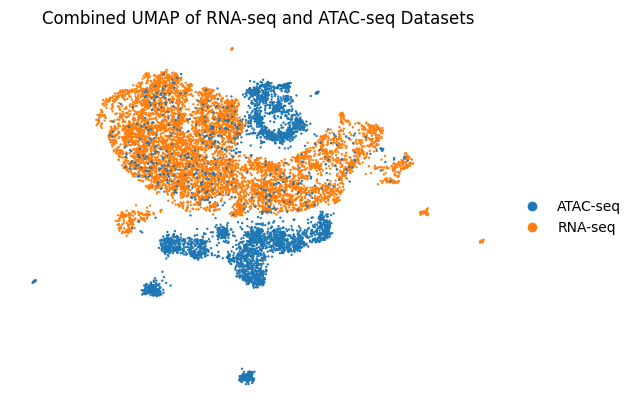

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'rna' and 'atac' are your AnnData objects

# Combine the embeddings from both datasets
combined_embeddings = np.vstack([adata_rna12.obsm['X_scVI'], adata_atac12.obsm['X_scVI']])

# Create an AnnData object for the combined embeddings
combined_adata = sc.AnnData(X=combined_embeddings)

# Optionally, you can add a 'dataset' category to distinguish between RNA-seq and ATAC-seq in the plot
combined_adata.obs['dataset'] = ['RNA-seq'] * adata_rna12.n_obs + ['ATAC-seq'] * adata_atac12.n_obs

sc.pp.neighbors(combined_adata, use_rep='X', n_neighbors=15, metric='euclidean')

# Compute UMAP
sc.tl.umap(combined_adata)

# Plotting
sc.pl.umap(combined_adata, color='dataset', title='Combined UMAP of RNA-seq and ATAC-seq Datasets', frameon=False)



Our data look that it's being merged rather than integrated/translated. Let's take other steps and then we can look into how we can improve that.

0


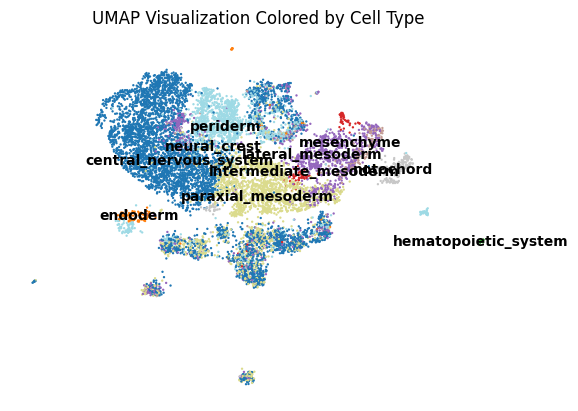

In [ ]:
cell_types_rna = adata_rna12.obs['zebrafish_anatomy_ontology_class'].reset_index(drop=True)
cell_types_atac = adata_atac12.obs['transferred_labels'].reset_index(drop=True)

# Concatenate ignoring the indices to ensure no NA values are produced
combined_cell_types = pd.concat([cell_types_rna, cell_types_atac], ignore_index=True)

# Assign concatenated cell type labels back to combined_adata
combined_adata.obs['cell_type'] = np.array(combined_cell_types)

# Check to ensure no N/A values
print(combined_adata.obs['cell_type'].isna().sum())  # Should print 0 if everything is correct

# Now you can plot
sc.pl.umap(combined_adata, color='cell_type', title='UMAP Visualization Colored by Cell Type', frameon=False, legend_loc='on data', palette='tab20')

Great! now we can use foscttm metric to mesaure our integration. We are going to use different approach to do that, first we will use Latent Semantic Indexing (LSI) for ATAC-seq, and scVI embeddings for RNA-seq. The second appraoch would be using scVI embedding for both datasets.

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50)
adata_atac12.obsm['X_lsi'] = svd.fit_transform(adata_atac12.X)
adata_atac12.uns['lsi'] = {'components': svd.components_, 'explained_variance': svd.explained_variance_}


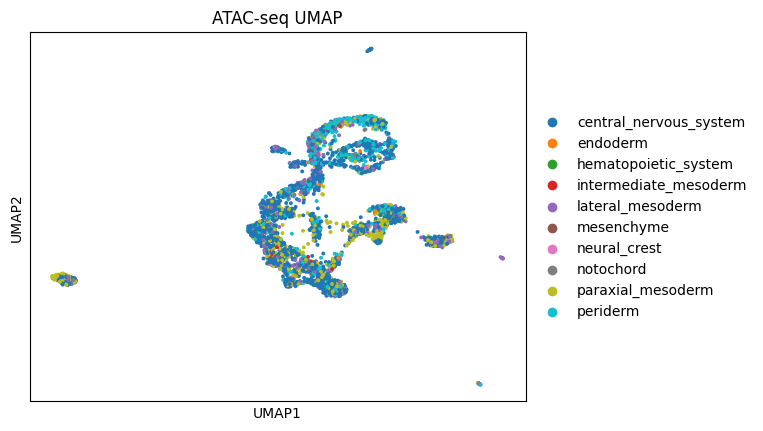

[[-0.07504398 -6.21589   ]
 [ 3.29584    10.769571  ]
 [ 2.6289873   7.2639356 ]
 ...
 [ 0.7564541   7.2707    ]
 [ 4.977296    6.2698984 ]
 [ 7.295251    8.102973  ]]


In [ ]:
sc.pp.neighbors(adata_atac12, use_rep='X_lsi', n_neighbors=20, metric='cosine')

# Compute UMAP
sc.tl.umap(adata_atac12)

# UMAP results are stored in atac.obsm['X_umap']
# You can plot to visualize
sc.pl.umap(adata_atac12, color='transferred_labels', title='ATAC-seq UMAP')

# Optionally, you can check or use the UMAP coordinates
print(adata_atac12.obsm['X_umap'])

In [ ]:
print(
    "Average FOSCTTM score of translating ATAC onto RNA: ",
    foscttm(adata_rna12.obsm["X_umap"], adata_atac12.obsm["X_umap"]),
)

Average FOSCTTM score of translating ATAC onto RNA:  0.5126


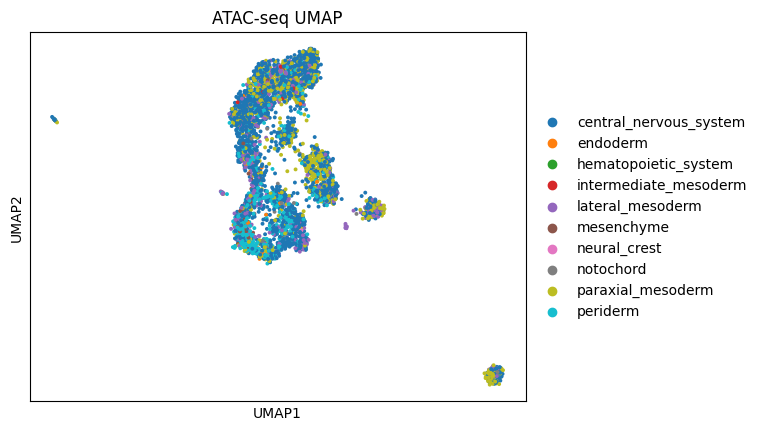

[[ 5.7664638 18.747925 ]
 [ 2.183282   6.6207905]
 [ 4.1084332  9.893419 ]
 ...
 [ 5.2760205  7.8319225]
 [ 6.464361   8.375853 ]
 [ 6.0653677  7.0721006]]


In [ ]:
sc.pp.neighbors(adata_atac12, use_rep='X_scVI', n_neighbors=20, metric='euclidean')

# Compute UMAP
sc.tl.umap(adata_atac12)

# UMAP results are stored in atac.obsm['X_umap']
# You can plot to visualize
sc.pl.umap(adata_atac12, color='transferred_labels', title='ATAC-seq UMAP')

# Optionally, you can check or use the UMAP coordinates
print(adata_atac12.obsm['X_umap'])

In [ ]:
print(
    "Average FOSCTTM score of translating ATAC onto RNA: ",
    foscttm(adata_rna12.obsm["X_umap"], adata_atac12.obsm["X_umap"]),
)

Average FOSCTTM score of translating ATAC onto RNA:  0.2626


The score for LSI integration is way higher than scVI. It also makes sense since ATAC-seq data is binary data that is typically very sparse, with many zeros indicating regions of the genome that are not accessible. LSI, being a technique originally designed for text data (which is similarly sparse), is suitable for reducing the dimensionality of such data type. On the other hand, scVI (single-cell Variational Inference) is particularly suited for RNA-seq data because it deals with continuous counts of gene expression.

For datasets that are either extensive and of higher quality or contain distinct data not available elsewhere (like specific cell type annotations or unique data forms), it is common to use this dataset as a reference. By mapping queries onto this reference, we can analyze and understand these query datasets within the framework of the already established reference. In our case we have labels in our RNA-seq and the data modality is different from our query dataset (ATAC-seq), so it would be nice to have this translation to our reference dataset (RNA-seq).
In the next notebook, we will use moscot library to achieve this.